In [1]:
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install seaborn
!pip install statsmodels

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats # QQ plot
from sklearn.preprocessing import OneHotEncoder # Dummy variable
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split # Set spliting
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
test = pd.read_csv('/content/sample_data/california_housing_test.csv')
sales= pd.read_csv('/content/sample_data/california_housing_train.csv')


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
Length1,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
Length2,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
Length3,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


In [ ]:
data1=data.to_numpy()
data1.dtype

dtype('O')

In [9]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_frame = data_frame[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_frame.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_array = data_frame[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_array.to_numpy()
    return(feature_matrix, output_array)

In [10]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix,weights)
    return(predictions)

In [11]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = np.dot(errors,feature) * 2
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    elif feature_is_constant == False:
        derivative = np.dot(errors,feature) * 2 + 2*l2_penalty*weight
    else:
        derivative = 'derivative not exist!!!'
    return derivative

In [12]:
(example_features, example_output) = get_numpy_data(sales, ['total_bedrooms'], 'median_income') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20.)
print ('')

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2.)

159276711290.4964
159276711290.4964

183301638.34460002
183301638.3446


In [38]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print ('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix,weights)
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print ('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))
        
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i ==0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - step_size * derivative
    print ('Done with gradient descent at iteration ', iteration)
    print ('Learned weights = ', str(weights))
    return weights


In [26]:
simple_features = ['total_bedrooms']
my_output = 'median_income'

In [27]:
train_data = sales
test_data = test

In [28]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

In [29]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

In [39]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 0, max_iterations)


Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  318291.44161504996
Iteration = 2
Cost function =  313310.89034007257
Iteration = 3
Cost function =  308487.7843154923
Iteration = 4
Cost function =  303817.14637749986
Iteration = 5
Cost function =  299294.15670053236
Iteration = 6
Cost function =  294914.14782349166
Iteration = 7
Cost function =  290672.5998331952
Iteration = 8
Cost function =  286565.1357000866
Iteration = 9
Cost function =  282587.51676139433
Iteration = 10
Cost function =  278735.63834707683
Iteration = 20
Cost function =  246317.2683746465
Iteration = 30
Cost function =  222805.50699919445
Iteration = 40
Cost function =  205753.35459903057
Iteration = 50
Cost function =  193386.09967238837
Iteration = 60
Cost function =  184416.61455215036
Iteration = 70
Cost function =  177911.39673393226
Iteration = 80
Cost function =  173193.4139792432
Iteration = 90
Cost function =  169771.64173292328
Iteration = 100
Cost function =  167289.9594145002

In [40]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 1e11, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  318291.44161504996
Iteration = 2
Cost function =  313812.9433269447
Iteration = 3
Cost function =  311059.7303196773
Iteration = 4
Cost function =  309367.1557262237
Iteration = 5
Cost function =  308326.6204548183
Iteration = 6
Cost function =  307686.93364596163
Iteration = 7
Cost function =  307293.6729106476
Iteration = 8
Cost function =  307051.9053589063
Iteration = 9
Cost function =  306903.26993534877
Iteration = 10
Cost function =  306811.8885287411
Iteration = 20
Cost function =  306667.0534471613
Iteration = 30
Cost function =  306665.77914827847
Iteration = 40
Cost function =  306665.6117285479
Iteration = 50
Cost function =  306665.45284315373
Iteration = 60
Cost function =  306665.2940236631
Iteration = 70
Cost function =  306665.1352047828
Iteration = 80
Cost function =  306664.9763860094
Iteration = 90
Cost function =  306664.8175673392
Iteration = 100
Cost function =  306664.65874

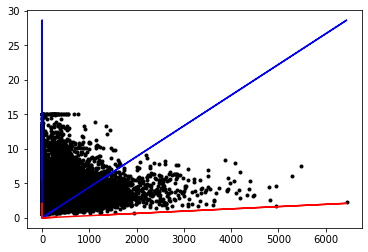

In [41]:
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [43]:
predictions = predict_output(simple_test_feature_matrix, initial_weights)
error = test_output - predictions
RSS = np.dot(error,error)

print (RSS)

53800.15773016


In [44]:
predictions = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
error = test_output - predictions
RSS = np.dot(error,error)
print (RSS)

26378.788463991896


In [45]:
predictions = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
error = test_output - predictions
RSS = np.dot(error,error)
print (RSS)

49935.15831916767


In [ ]:
data_2 = data.copy() # Copying before dropping columns
data_2 = data_2.drop(['Length1','Length2'], axis = 1) 

data_2 = data_2[['Species','Length3','Height','Width','Weight']] # Rearrange columns.

data_2.head(3)

,Species,Length3,Height,Width,Weight
0,Bream,30.0,11.5200,4.0200,242.0
1,Bream,31.2,12.4800,4.3056,290.0
2,Bream,31.1,12.3778,4.6961,340.0


In [ ]:
X = data_2.iloc[:,0:4].values 

y = data_2.iloc[:,-1].values

In [ ]:
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   
    remainder='passthrough')
X = np.array(ct.fit_transform(X), dtype=np.float)
np.set_printoptions(suppress=True)

In [ ]:
X = X[:,1:]
X.shape

(159, 9)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # Set Splitting



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardizer(data):
    data_columns = data.columns  # agar nama column tidak hilang
    data_index = data.index # agar index tidak hilang
    normalize = StandardScaler()
    normalize.fit(data)
    
    normalize_x = pd.DataFrame(normalize.transform(data))
    normalize_x.columns = data_columns
    return normalize_x, normalize

X_train, normalize = standardizer(X_train)


In [ ]:
regression = LinearRegression() 
regression.fit(X_train, y_train)

In [ ]:
y_pred = regression.predict(X_test) # Predictions

Prediccion_y = pd.DataFrame({'Prediction_y': y_pred})
Prediccion_y

Y = pd.DataFrame({'Y test': y_test}) # Df 
Comparacion = Y.join(Prediccion_y) 
Comparacion.head()

,Y test,Prediction_y
0,390.0,441.004108
1,0.0,98.176563
2,170.0,209.017037
3,160.0,183.344960
4,556.0,655.478760


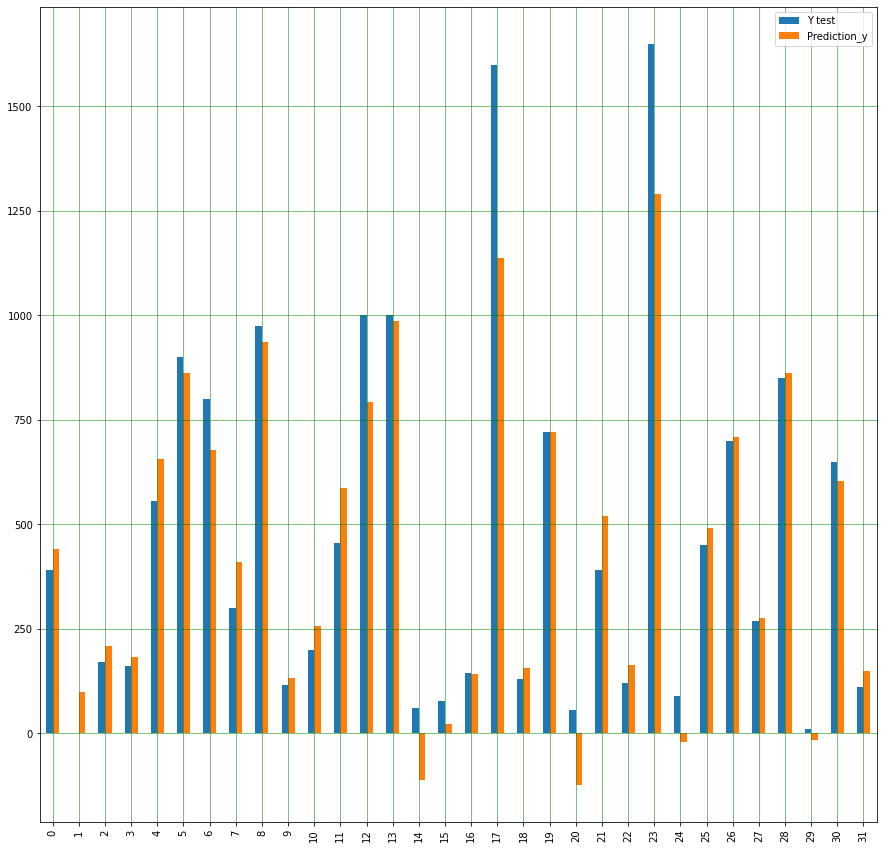

In [ ]:
Comparacion.plot(kind = 'bar', figsize=(15,15))
plt.grid(which = 'both', linestyle = '-', linewidth = '0.5', color = 'green')
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))
Adj_r2 = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (156 - 1) / (156 - 9 - 1)
print('R2 adjusted', Adj_r2)

Mean Absolute Error: 86.43642336547391
Mean Squared Error: 17610.985365653163
Root Mean Squared Error: 132.70638781028276
R2: 0.9074813476101219
R2 adjusted 0.9017781430107459


In [ ]:
Error = Comparacion['Y test'] - Comparacion['Prediction_y']
temp = {'Error' : Error, 'Predicted_y' : Comparacion['Prediction_y']}
Error_df = pd.DataFrame(temp)
Error_df.head()

,Error,Predicted_y
0,-51.004108,441.004108
1,-98.176563,98.176563
2,-39.017037,209.017037
3,-23.344960,183.344960
4,-99.478760,655.478760


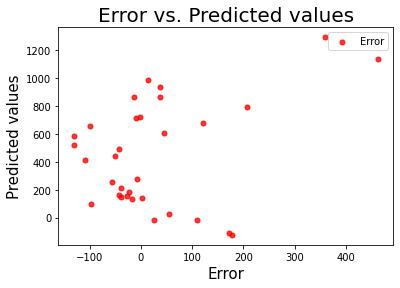

In [ ]:
plt.scatter(Error_df['Error'], Error_df['Predicted_y'], c = 'red', s = 25, alpha = 0.8, label = 'Error')
plt.title('Error vs. Predicted values', fontsize = 20)
plt.xlabel('Error', fontsize = 15)
plt.legend()
plt.ylabel('Predicted values', fontsize = 15)
plt.show()

In [ ]:
from sklearn.linear_model import Ridge

R_model=Ridge(alpha=0.1)
R_model.fit(X_train,y_train)

y_test_predict_Ridge=R_model.predict(X_test) # Predictions
Prediction_y = pd.DataFrame({'Prediction_y': y_test_predict_Ridge})
Prediction_y
Y = pd.DataFrame({'Y test': y_test}) # Df 
Comparasion = Y.join(Prediction_y) 
Comparasion.head()

,Y test,Prediction_y
0,390.0,460.527347
1,0.0,93.315226
2,170.0,209.365379
3,160.0,180.556894
4,556.0,655.498099


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_predict_Ridge))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_predict_Ridge))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_predict_Ridge)))
print('R2:', metrics.r2_score(y_test, y_test_predict_Ridge))
Adj_r2 = 1 - (1 - metrics.r2_score(y_test, y_test_predict_Ridge)) * (156 - 1) / (156 - 9 - 1)
print('R2 adjusted', Adj_r2)



Mean Absolute Error: 84.50221868005502
Mean Squared Error: 16875.647285878502
Root Mean Squared Error: 129.9063019482831
R2: 0.9113444186864511
R2 adjusted 0.9058793486054789


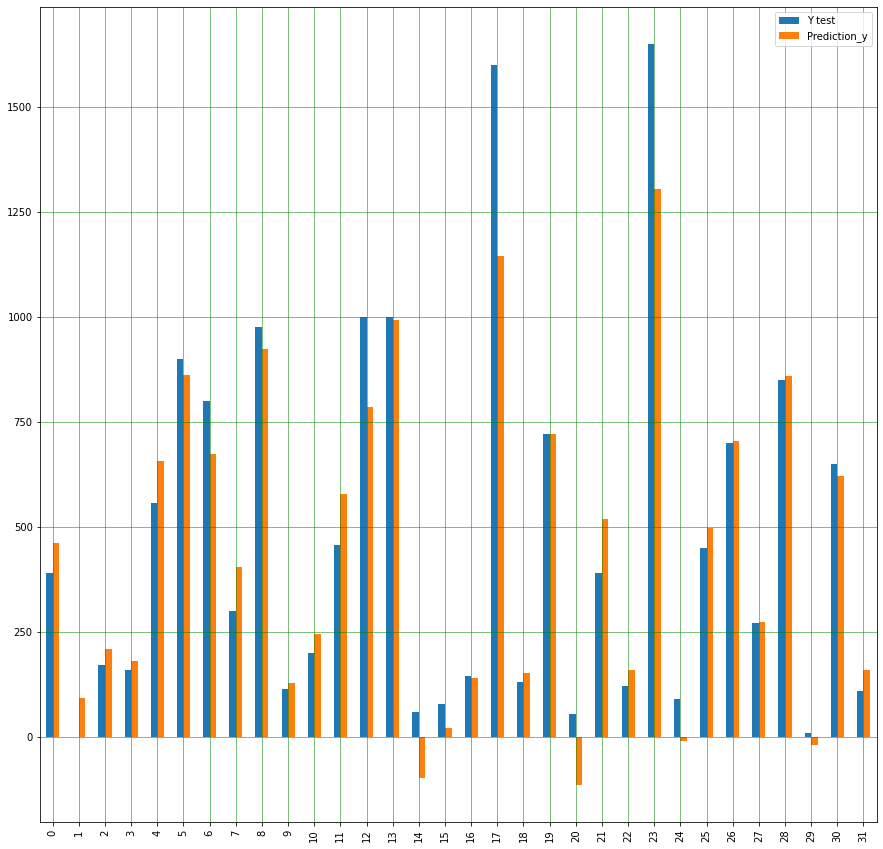

In [ ]:
Comparasion.plot(kind = 'bar', figsize=(15,15))
plt.grid(which = 'both', linestyle = '-', linewidth = '0.5', color = 'green')
plt.show()

In [ ]:
Error = Comparasion['Y test'] - Comparasion['Prediction_y']
temp = {'Error' : Error, 'Predicted_y' : Comparasion['Prediction_y']}
Error_df = pd.DataFrame(temp)
Error_df.head()

,Error,Predicted_y
0,-70.527347,460.527347
1,-93.315226,93.315226
2,-39.365379,209.365379
3,-20.556894,180.556894
4,-99.498099,655.498099


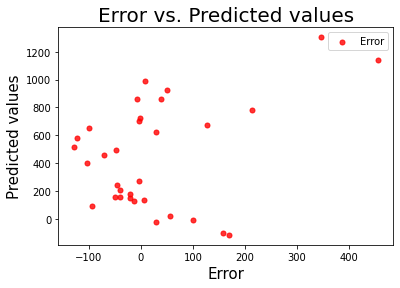

In [ ]:
plt.scatter(Error_df['Error'], Error_df['Predicted_y'], c = 'red', s = 25, alpha = 0.8, label = 'Error')
plt.title('Error vs. Predicted values', fontsize = 20)
plt.xlabel('Error', fontsize = 15)
plt.legend()
plt.ylabel('Predicted values', fontsize = 15)
plt.show()